# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys

%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [5]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg

## Data Preparation

In [6]:
core_dtypes_pd = {'AGE': float,
 'AWEEKEND': float,
 'DIED': float,
 'DISCWT': float,
 'DISPUNIFORM': float,
 'DMONTH': float,
 'DQTR': float,
 'DRG': float,
 'DRGVER': float,
 'DRG_NoPOA': float,
 'DX1': bytes,
 'DX10': bytes,
 'DX11': bytes,
 'DX12': bytes,
 'DX13': bytes,
 'DX14': bytes,
 'DX15': bytes,
 'DX16': bytes,
 'DX17': bytes,
 'DX18': bytes,
 'DX19': bytes,
 'DX2': bytes,
 'DX20': bytes,
 'DX21': bytes,
 'DX22': bytes,
 'DX23': bytes,
 'DX24': bytes,
 'DX25': bytes,
 'DX26': bytes,
 'DX27': bytes,
 'DX28': bytes,
 'DX29': bytes,
 'DX3': bytes,
 'DX30': bytes,
 'DX4': bytes,
 'DX5': bytes,
 'DX6': bytes,
 'DX7': bytes,
 'DX8': bytes,
 'DX9': bytes,
 'DXCCS1': float,
 'DXCCS10': float,
 'DXCCS11': float,
 'DXCCS12': float,
 'DXCCS13': float,
 'DXCCS14': float,
 'DXCCS15': float,
 'DXCCS16': float,
 'DXCCS17': float,
 'DXCCS18': float,
 'DXCCS19': float,
 'DXCCS2': float,
 'DXCCS20': float,
 'DXCCS21': float,
 'DXCCS22': float,
 'DXCCS23': float,
 'DXCCS24': float,
 'DXCCS25': float,
 'DXCCS26': float,
 'DXCCS27': float,
 'DXCCS28': float,
 'DXCCS29': float,
 'DXCCS3': float,
 'DXCCS30': float,
 'DXCCS4': float,
 'DXCCS5': float,
 'DXCCS6': float,
 'DXCCS7': float,
 'DXCCS8': float,
 'DXCCS9': float,
 'ECODE1': bytes,
 'ECODE2': bytes,
 'ECODE3': bytes,
 'ECODE4': bytes,
 'ELECTIVE': float,
 'E_CCS1': float,
 'E_CCS2': float,
 'E_CCS3': float,
 'E_CCS4': float,
 'FEMALE': float,
 'HCUP_ED': float,
 'HOSP_NRD': float,
 'KEY_NRD': float,
 'LOS': float,
 'MDC': float,
 'MDC_NoPOA': float,
 'NCHRONIC': float,
 'NDX': float,
 'NECODE': float,
 'NPR': float,
 'NRD_DaysToEvent': float,
 'NRD_STRATUM': float,
 'NRD_VisitLink': bytes,
 'ORPROC': float,
 'PAY1': float,
 'PL_NCHS': float,
 'PR1': bytes,
 'PR10': bytes,
 'PR11': bytes,
 'PR12': bytes,
 'PR13': bytes,
 'PR14': bytes,
 'PR15': bytes,
 'PR2': bytes,
 'PR3': bytes,
 'PR4': bytes,
 'PR5': bytes,
 'PR6': bytes,
 'PR7': bytes,
 'PR8': bytes,
 'PR9': bytes,
 'PRCCS1': float,
 'PRCCS10': float,
 'PRCCS11': float,
 'PRCCS12': float,
 'PRCCS13': float,
 'PRCCS14': float,
 'PRCCS15': float,
 'PRCCS2': float,
 'PRCCS3': float,
 'PRCCS4': float,
 'PRCCS5': float,
 'PRCCS6': float,
 'PRCCS7': float,
 'PRCCS8': float,
 'PRCCS9': float,
 'PRDAY1': float,
 'PRDAY10': float,
 'PRDAY11': float,
 'PRDAY12': float,
 'PRDAY13': float,
 'PRDAY14': float,
 'PRDAY15': float,
 'PRDAY2': float,
 'PRDAY3': float,
 'PRDAY4': float,
 'PRDAY5': float,
 'PRDAY6': float,
 'PRDAY7': float,
 'PRDAY8': float,
 'PRDAY9': float,
 'REHABTRANSFER': float,
 'RESIDENT': float,
 'SAMEDAYEVENT': bytes,
 'SERVICELINE': float,
 'TOTCHG': float,
 'YEAR': float,
 'ZIPINC_QRTL': float}

In [7]:
ami_index = pd.read_csv(path+'cohorts/ami_index.csv', dtype=core_dtypes_pd)

train_comorb = pd.read_csv(path+'cohorts/ami/comorb_train.csv')
tst_comorb = pd.read_csv(path+'cohorts/ami/comorb_tst.csv')

train_df = ami_index[ami_index['KEY_NRD'].isin(train_comorb['KEY_NRD'])]
tst_df = ami_index[ami_index['KEY_NRD'].isin(tst_comorb['KEY_NRD'])]

N_train = len(train_df)
N_tst = len(tst_df)
all_df = pd.concat([train_df, tst_df])

del(ami_index, train_comorb, tst_comorb)

In [8]:
train_df.to_csv(path+'cohorts/ami/DX_train.csv', index=False)
tst_df.to_csv(path+'cohorts/ami/DX_tst.csv', index=False)

In [7]:
train_df = pd.read_csv(path+'cohorts/ami/DX_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'cohorts/ami/DX_tst.csv', dtype=core_dtypes_pd)

In [8]:
train_df.shape

(163671, 150)

In [8]:
all_df = pd.concat([train_df, tst_df])

Define the dictionaries for DX, DX1 and hosp, from value to int. 

In [9]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

DX_series = pd.concat([all_df[DX] for DX in DXs])
DX_series = DX_series.fillna('missing')
DX_series[DX_series.isin(['invl', 'incn'])] = 'missing'

In [10]:
multi_ccs = pd.read_csv(path+'ccs_multi_dx_tool_2015.csv')

multi_ccs.columns = ['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL1_LABEL', 'CCS_LVL2', 'CCS_LVL2_LABEL', 'CCS_LVL3', 'CCS_LVL3_LABEL', 
                    'CCS_LVL4', 'CCS_LVL4_LABEL']

multi_ccs.ICD9CM_CODE = multi_ccs.ICD9CM_CODE.apply(lambda x:x.replace("'", "").replace(' ', ''))
for j in range(1, 5):
    multi_ccs['CCS_LVL'+str(j)] = multi_ccs['CCS_LVL'+str(j)].apply(lambda x:x.replace("'", "").replace(' ', ''))

multi_ccs = multi_ccs[['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL2', 'CCS_LVL3', 'CCS_LVL4']]

In [11]:
unclassified = set(multi_ccs.loc[multi_ccs.CCS_LVL1 == '18', 'ICD9CM_CODE'])
DX_series.loc[DX_series.isin(unclassified)] = 'missing'

In [12]:
rare_cutpoint = 10
code_freq = DX_series.value_counts()
rare_code = code_freq[code_freq<rare_cutpoint].index
DX_series.loc[DX_series.isin(rare_code)] = 'missing' # also consider coding as 'rare'

In [13]:
DX_series = DX_series.astype('category')
DX_cat = DX_series.cat.categories
n_DX_cat = len(DX_cat)
DX_int_cat = list(range(n_DX_cat)[1:]) +[0]
DX_dict = dict(zip(DX_cat, DX_int_cat))

In [14]:
n_DX_cat

2378

In [36]:
N_PR = 15
PRs = ['PR'+str(n) for n in range(1, N_PR+1)]

PR_series = pd.concat([all_df[PR] for PR in PRs])

PR_series = PR_series.fillna('missing')
PR_series[PR_series.isin(['invl', 'incn'])] = 'missing'

pr_rare_cutpoint = 5
pr_code_freq = PR_series.value_counts()
pr_rare_code = pr_code_freq[pr_code_freq<pr_rare_cutpoint].index
PR_series.loc[PR_series.isin(pr_rare_code)] = 'missing' # also consider coding as 'rare'

PR_series = PR_series.astype('category')
PR_cat = PR_series.cat.categories
n_PR_cat = len(PR_cat)
PR_int_cat = list(range(n_PR_cat)[1:]) +[0]
PR_dict = dict(zip(PR_cat, PR_int_cat))

In [15]:
DX1_series = all_df['DX1'].astype('category')
DX1_cat = DX1_series.cat.categories
DX1_int_cat = range(len(DX1_cat))

DX1_dict = dict(zip(DX1_cat, DX1_int_cat))

In [16]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories

hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

## Multi-Level CCS Codes

### Define the parent matrix

Read the ICD9 CCS multi-level category dictionary file. 

In [23]:
multi_ccs = pd.read_csv(path+'ccs_multi_dx_tool_2015.csv')

multi_ccs.columns = ['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL1_LABEL', 'CCS_LVL2', 'CCS_LVL2_LABEL', 'CCS_LVL3', 'CCS_LVL3_LABEL', 
                    'CCS_LVL4', 'CCS_LVL4_LABEL']

multi_ccs.ICD9CM_CODE = multi_ccs.ICD9CM_CODE.apply(lambda x:x.replace("'", "").replace(' ', ''))
for j in range(1, 5):
    multi_ccs['CCS_LVL'+str(j)] = multi_ccs['CCS_LVL'+str(j)].apply(lambda x:x.replace("'", "").replace(' ', ''))

In [18]:
multi_ccs = multi_ccs[['ICD9CM_CODE', 'CCS_LVL1', 'CCS_LVL2', 'CCS_LVL3', 'CCS_LVL4']]

In [21]:
multi_ccs.shape

(15072, 5)

In [23]:
multi_ccs.CCS_LVL1_LABEL.value_counts()

Injury and poisoning                                                                 2764
Residual codes; unclassified; all E codes [259. and 260.]                            1589
Diseases of the nervous system and sense organs                                      1587
Infectious and parasitic diseases                                                    1226
Complications of pregnancy; childbirth; and the puerperium                           1205
Neoplasms                                                                            1114
Diseases of the musculoskeletal system and connective tissue                          863
Diseases of the digestive system                                                      757
Mental Illness                                                                        597
Diseases of the circulatory system                                                    553
Diseases of the genitourinary system                                                  498
Endocrine;

Create one list to store all possible ICD9 code and their CCS multi-level in a list. Creat two dataframe to store the parent of each code and the indices of the parent. 

In [17]:
ami_ccs = multi_ccs.loc[multi_ccs.ICD9CM_CODE.isin(DX_cat)]

In [19]:
ami_ccs.shape

(3014, 5)

In [18]:
ccs_cat = pd.concat([ami_ccs.CCS_LVL1, ami_ccs.CCS_LVL2, ami_ccs.CCS_LVL3, ami_ccs.CCS_LVL4]).astype('category').cat.categories

In [165]:
len(ccs_cat)

562

In [19]:
all_codes = [DX_cat[-1]]+list(DX_cat[:-1]) + list(ccs_cat[1:])

In [29]:
len(all_codes)

2938

In [20]:
def get_CCS_ind(code):
    try:
        ind = all_codes.index(code)
    except ValueError:
        ind = -1
    return ind

def get_CCS_lvl(code):
    if code=='':
        return 0
    else:
        lvl = len(code.split('.'))
        return lvl

In [21]:
ami_ccs = ami_ccs.set_index(ami_ccs.ICD9CM_CODE, drop=True).drop(['ICD9CM_CODE'], axis=1)

ami_ccs['finest_non_empty'] = ami_ccs.CCS_LVL4
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL3[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL2[ami_ccs.finest_non_empty == '']
ami_ccs.finest_non_empty[ami_ccs.finest_non_empty==''] = ami_ccs.CCS_LVL1[ami_ccs.finest_non_empty == '']

DX_parent = ami_ccs[['finest_non_empty']]

DX_parent.columns = ['parent_code']

DX_parent = DX_parent.assign(parent_index=DX_parent.parent_code.apply(lambda x:all_codes.index(x)).values)
DX_parent = DX_parent.assign(parent_level=DX_parent.parent_code.apply(get_CCS_lvl).values)
DX_parent = DX_parent.append(pd.DataFrame(index=['missing'], data=dict(parent_code = ['NA'], 
                                                                                       parent_index=[-1], parent_level=[0])))

In [22]:
CCS_parent = pd.DataFrame(dict(CCS_code=ccs_cat[1:]))

CCS_parent = CCS_parent.assign(parent_code=CCS_parent.CCS_code.apply(lambda x:'.'.join(x.split('.')[:-1])))

CCS_parent = CCS_parent.assign(parent_index=CCS_parent.parent_code.apply(get_CCS_ind).values)
CCS_parent = CCS_parent.assign(parent_level=CCS_parent.parent_code.apply(get_CCS_lvl).values)
CCS_parent = CCS_parent.set_index(CCS_parent.CCS_code, drop=True).drop(['CCS_code'], axis=1)

In [52]:
CCS_parent

,parent_code,parent_index,parent_level
CCS_code,,,
1,,-1,0
1.1,1,2378,1
1.1.1,1.1,2379,2
1.1.2,1.1,2379,2
1.1.2.1,1.1.2,2381,3
1.1.2.2,1.1.2,2381,3
1.1.2.3,1.1.2,2381,3
1.1.2.4,1.1.2,2381,3
1.1.2.5,1.1.2,2381,3


In [53]:
DX_parent

,parent_code,parent_index,parent_level
01190,1.1.1,2380,3
V1201,1.1.1,2380,3
0380,1.1.2.1,2382,4
03810,1.1.2.2,2383,4
03811,1.1.2.2,2383,4
03812,1.1.2.2,2383,4
03819,1.1.2.2,2383,4
03842,1.1.2.3,2384,4
03840,1.1.2.4,2385,4
03843,1.1.2.4,2385,4


In [23]:
parent_df = pd.concat([DX_parent, CCS_parent], axis=0)

In [24]:
parent_mat = np.identity(len(all_codes))

In [38]:
for i, c in enumerate(all_codes):
    parent_ind = parent_df.loc[c, 'parent_index']
    if not parent_ind == -1:
        parent_mat[i, parent_ind] = -1

In [25]:
for i, c in enumerate(all_codes):
    parent_ind = parent_df.loc[c, 'parent_index']
    parent_lvl = parent_df.loc[c, 'parent_level']
    if not parent_ind == -1:
        parent_mat[i, parent_ind] = -parent_lvl
        parent_mat[i, i] = parent_lvl

In [35]:
for i, c in enumerate(all_codes):
    parent_ind = parent_df.loc[c, 'parent_index']
    parent_lvl = parent_df.loc[c, 'parent_level']
    if not parent_ind == -1:
        parent_mat[i, parent_ind] = -np.sqrt(parent_lvl)
        parent_mat[i, i] = np.sqrt(parent_lvl)

In [26]:
no_parent = np.where(parent_mat.sum(axis=1)>0)[0]

In [27]:
np.array(all_codes)[no_parent]

array(['missing', '1', '10', '11', '12', '13', '14', '16', '17', '2', '3',
       '4', '5', '6', '7', '8', '9'], dtype='<U9')

In [28]:
parent_mat = parent_mat[parent_mat.sum(axis=1)==0, :]

In [29]:
parent_mat.shape

(2921, 2938)

In [36]:
np.save(path+'cohorts/ami/parent_mat3.npy', parent_mat) #code freq >= 5, no CCS cat 18

## Further Predictors

### Data Formatting

In [83]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)
N_trn = len(trn_df)
N_val = len(val_df)
train_df = pd.concat([trn_df, val_df])

In [84]:
DX_df = train_df[DXs]

DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
DX_df[DX_df.isin(rare_code)] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values

DX_mat.sort(axis=1)
#DX_mat = DX_mat[:, ::-1]

DX_mat_trn = DX_mat[:N_trn, ]
DX_mat_val = DX_mat[N_trn:, ]

In [85]:
PR_df = train_df[PRs]

PR_df = PR_df.fillna('missing')
PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
PR_df[PR_df.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df[pr] = PR_df[pr].map(PR_dict)

PR_mat = PR_df.values

PR_mat.sort(axis=1)
#DX_mat = DX_mat[:, ::-1]

PR_mat_trn = PR_mat[:N_trn, ]
PR_mat_val = PR_mat[N_trn:, ]

In [86]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [89]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

DX1_series = train_df['DX1'].map(DX1_dict)

DX1_mat = np.zeros((len(DX1_series), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series.values):
    DX1_mat[i, dx1] = 1

In [88]:
# if DX1 is embedded
DX1_series = train_df['DX1'].map(DX1_dict)
DX1_mat = DX1_series.values
DX1_mat_trn = DX1_mat[:N_trn]
DX1_mat_val = DX1_mat[N_trn:]

In [90]:
pay1_mat = to_categorical(train_df.PAY1.values)[:, 1:]

los_array = train_df.LOS.values
los_mean = np.mean(los_array)
los_std = np.std(los_array)
los_array = (los_array - los_mean)/los_std

ed_mat = to_categorical(train_df.HCUP_ED.values)

zipinc_mat = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]

transfer_mat = to_categorical(train_df.SAMEDAYEVENT.values)

In [91]:
other_mat = np.concatenate((demo_mat, DX1_mat, pay1_mat, los_array.reshape(los_array.shape+(1,)), ed_mat, zipinc_mat, 
                            transfer_mat), axis=1)
other_mat_trn = other_mat[:N_trn, ]
other_mat_val = other_mat[N_trn:, ]

In [92]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

## Model Building

In [53]:
from setsum_layer import SetSum, MaskedSum, MaskedDense

In [55]:
DX_embed_dim = 128
PR_embed_dim = 64
hosp_embed_dim = 1
DX1_embed_dim = 1

In [37]:
parent_mat = np.load(path+'cohorts/ami/parent_mat3.npy')

In [93]:
#DeepSet model with more dense layers
input_DX = Input(shape = (N_DX,))
DX_embed = Embedding(input_dim=parent_mat.shape[1], output_dim=DX_embed_dim, mask_zero=True,
                     embeddings_regularizer=Mat_reg(parent_mat, 2e-5, norm=1), name='DX_embed')(input_DX)
DX_feature = MaskedDense(DX_embed_dim, activation='relu')(DX_embed)
#DX_feature = MaskedDense(DX_embed_dim, activation='relu')(DX_feature)
DX_feature = MaskedSum()(DX_feature)

input_PR = Input(shape = (N_PR,))
PR_embed = Embedding(input_dim=n_PR_cat, output_dim=PR_embed_dim, mask_zero=True, name='PR_embed')(input_PR)
PR_feature = MaskedDense(PR_embed_dim, activation='relu')(PR_embed)
PR_feature = MaskedSum()(PR_feature)

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

input_other = Input(shape=(other_mat.shape[1], ))

merged = Concatenate(axis=1)([DX_feature, PR_feature, hosp_embed, input_other])

x = Dense(64, activation='relu')(merged)
#x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [94]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [95]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_ccs_masksum_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_ccs_masksum_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=30)

In [96]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [97]:
hist = model.fit([DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                 batch_size=128, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/20
145667/145667 [==============================] - 8s 56us/step - loss: 1.4234 - val_loss: 0.6839
AUC: 0.7196

Epoch 2/20
145667/145667 [==============================] - 6s 44us/step - loss: 1.2827 - val_loss: 0.6586
AUC: 0.7225

Epoch 3/20
145667/145667 [==============================] - 6s 44us/step - loss: 1.2621 - val_loss: 0.6202
AUC: 0.7242

Epoch 4/20
145667/145667 [==============================] - 6s 44us/step - loss: 1.2518 - val_loss: 0.6111
AUC: 0.7239

Epoch 5/20
145667/145667 [==============================] - 6s 44us/step - loss: 1.2436 - val_loss: 0.6444
AUC: 0.7240

Epoch 6/20
145667/145667 [==============================] - 6s 44us/step - loss: 1.2365 - val_loss: 0.6427
AUC: 0.7233

Epoch 7/20
145667/145667 [==============================] - 6s 44us/step - loss: 1.2288 - val_loss: 0.6144
AUC: 0.7211

Epoch 8/20
145667/145667 [==============================] - 6s 44us/step - loss: 1.2254 - val_loss: 0.6440
AU

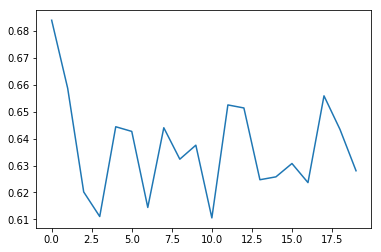

In [98]:
plt.plot(hist.history['val_loss'])

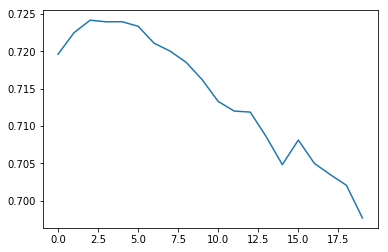

In [99]:
plt.plot(auccheckpoint.auc_history)

In [63]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(['invl', 'incn'])]
DX_df_tst[DX_df_tst.isin(rare_code)] = 'missing'
DX_df_tst[DX_df_tst.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

DX_mat_tst.sort(axis=1)
#DX_mat_tst = DX_mat_tst[:, ::-1]

In [64]:
PR_df_tst = tst_df[PRs]
PR_df_tst = PR_df_tst.fillna('missing')
PR_df_tst[PR_df_tst.isin(['invl', 'incn'])] = 'missing'
PR_df_tst[PR_df_tst.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df_tst[pr] = PR_df_tst[pr].map(PR_dict)

PR_mat_tst = PR_df_tst.values
PR_mat_tst.sort(axis=1)

In [65]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

In [66]:
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

In [67]:
DX1_series_tst = tst_df.DX1.map(DX1_dict)

DX1_mat_tst = np.zeros((len(tst_df), len(DX1_dict)))
for i, dx1 in enumerate(DX1_series_tst.values):
    DX1_mat_tst[i, dx1] = 1

In [68]:
pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]

los_array_tst = (tst_df.LOS.values - los_mean)/los_std

ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)

zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]

transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)

In [69]:
other_mat_tst = np.concatenate((demo_mat_tst, DX1_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst, transfer_mat_tst), axis=1)

In [100]:
model.load_weights(model_path+'ami_ccs_masksum_auc1.h5')

In [101]:
y = model.predict([DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 1s 33us/step


{0: 0.7121348559493651}

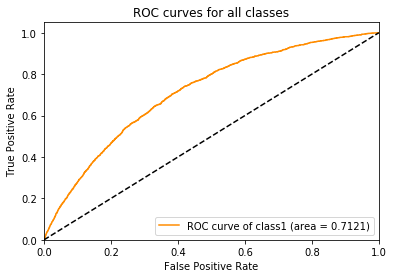

In [102]:
plot_roc(y_pred, y_true)

## Embedding Visualization

In [52]:
model.layers

In [75]:
embed_mat = model.layers[1].get_weights()[0]

In [76]:
np.linalg.norm(embed_mat, axis=1, ord=2)[:30]

array([0.27371907, 0.02746173, 0.02711867, 0.02759813, 0.02779855,
       0.0377774 , 0.04125843, 0.03902006, 0.03486356, 0.0380565 ,
       0.0385935 , 0.03802396, 0.03793211, 0.03798343, 0.03800374,
       0.03801001, 0.03802638, 0.03894252, 0.03806452, 0.0381002 ,
       0.03877238, 0.04099286, 0.03906104, 0.03905932, 0.03906114,
       0.0419651 , 0.03902812, 0.03908337, 0.0400243 , 0.03901803],
      dtype=float32)

In [96]:
np.linalg.norm(embed_mat, axis=1, ord=2)[:30]

array([0.19206613, 0.05574033, 0.05200075, 0.05206684, 0.06145821,
       0.09432068, 0.05461602, 0.03741015, 0.05191894, 0.03062067,
       0.04970593, 0.05317962, 0.05420603, 0.03656052, 0.04274737,
       0.04807642, 0.05005065, 0.04716379, 0.04575374, 0.03864745,
       0.03666022, 0.03635335, 0.03762525, 0.04590897, 0.03675134,
       0.03597372, 0.03329653, 0.05921885, 0.06657047, 0.05399343],
      dtype=float32)

In [85]:
distances = np.linalg.norm(np.dot(parent_mat, embed_mat), axis=1, ord=2)

In [59]:
from sklearn import decomposition, manifold

In [60]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

In [78]:
embed_tsne = tsne.fit_transform(embed_mat[1:(n_DX_cat-2),:])

In [79]:
ccs_lvl1 = [ami_ccs.loc[c, 'CCS_LVL1'] for c in all_codes[1:(n_DX_cat-2)]]

fine_group = [ami_ccs.loc[c, 'finest_non_empty'] for c in all_codes[1:(n_DX_cat-2)]]

plot_df = pd.DataFrame(dict(x=embed_tsne[:, 0], y=embed_tsne[:, 1], lvl1=ccs_lvl1, fine_group=fine_group))

In [80]:
plot_df = plot_df.assign(level=[len(g.split('.')) for g in plot_df.fine_group])

In [81]:
groups = plot_df.groupby('lvl1')

gkey = groups.groups.keys()

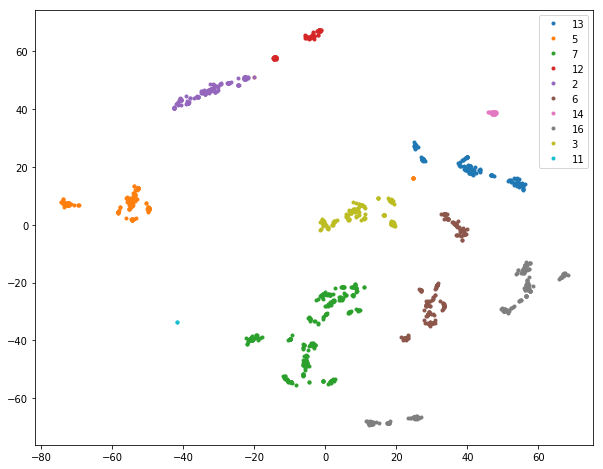

In [82]:
fig, ax = plt.subplots(figsize=(10, 8))
for name in list(gkey)[:10]:
    group = groups.get_group(name)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [83]:
top_fine_cat = ami_ccs.finest_non_empty.value_counts().iloc[:10].index

plot_subdf = plot_df.loc[plot_df.fine_group.isin(top_fine_cat)]

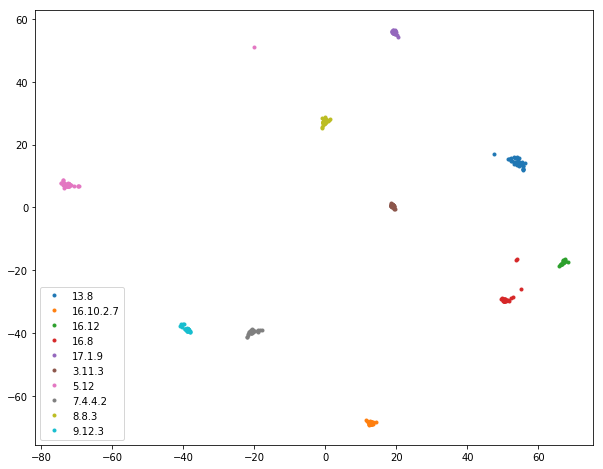

In [84]:
groups = plot_subdf.groupby('fine_group')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [153]:
plot_subdf = plot_df.loc[plot_df.lvl1=='3']

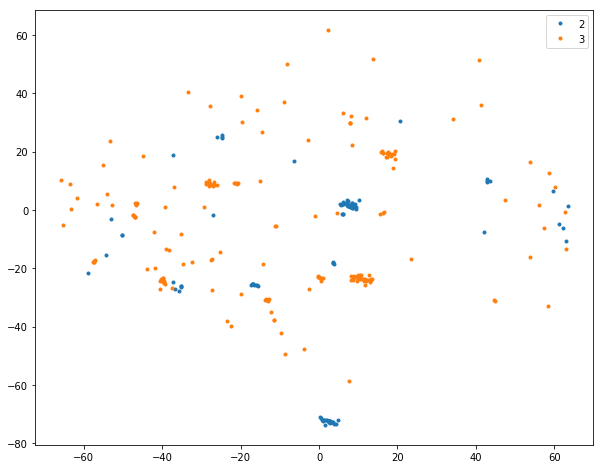

In [154]:
groups = plot_subdf.groupby('level')

fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

In [108]:
top_fine_cat

Index(['18', '13.8', '6.7.6', '16.12', '13.2.3', '16.8', '5.12', '6.9.1',
       '16.5', '2.16.2.5', '9.12.3', '16.10.2.7', '1.1.4', '9.2', '3.11.3',
       '3.4', '16.6.1', '17.1.9', '8.9', '10.1.8.3'],
      dtype='object')